## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import requests
import os
import io
import json
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
import random
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
(df['user_id'].nunique()) 

290584

d. The proportion of users converted.

In [5]:
converted=df.converted.mean()
user_converted=df.query('converted !=0').user_id.nunique()/df.user_id.nunique()
user_converted ,converted

(0.12104245244060237, 0.11965919355605512)

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
not_match=len(df.query('group=="treatment" & landing_page!="new_page"'))+len(df.query('group=="control" & landing_page=="new_page"'))
not_match

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().all()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df.drop(df.query('group=="treatment" & landing_page!="new_page"').index )
df2=df2.drop(df2.query('group=="control" & landing_page=="new_page"').index )
df2.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.user_id.drop_duplicates(inplace=True)  ,df2.drop(2893,inplace=True)

(None, None)

In [15]:
sum(df2.user_id.duplicated())

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
control_converted=df2.query('group=="control"')['converted']
control_converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
treatment_converted=df2.query('group=="treatment"')['converted']
treatment_converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
len(df2.query('landing_page=="new_page"'))/df2.shape[0]

0.5000619442226688

In [21]:
# we can see that the new - old <= 0 which means it's under the null 
different=treatment_converted.mean()-control_converted.mean()
different

-0.0015782389853555567

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**
- According to the probability we can see that the old control group has a higher probability to be converted than the new treatment page 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**


- If we assume the old page is better unless the new page proves to be definately better, then the null hypotheses is that the mean converted rate of the old page is greater or equal to the converted rate of the new page and the alternative hypothesis is that the mean converted rate of the new page is greater than the converted rate of the old page.

- Null Hypotheses: $p_{old}$ is equal greater or equal to $p_{new}$

- Alternative Hypothesis: $p_{old}$ is less than $p_{new}$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
df2.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [23]:
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old=df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
n_new=len(df2.query('group=="treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old=len(df2.query('group=="control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice([1,0],size=n_new, p=[p_new,1-p_new])


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([1,0],size=n_old, p=[p_old,1-p_old])


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
new_page_converted.mean()-old_page_converted.mean()

0.0015051283654890363

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

- The for loop takes too much time


p_diffs=[]

for _ in range(10000):

    new_page_converted = np.random.choice([1,0],size=n_new, p=[p_new,1-p_new])
    
    old_page_converted = np.random.choice([1,0],size=n_old, p=[p_old,1-p_old])
    
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

    
p_diffs=np.array(p_diffs)    

In [30]:
p_diffs=[]
new_converted_simulation=np.random.binomial(n_new,p_new,10000)/n_new
old_converted_simulation=np.random.binomial(n_old,p_old,10000)/n_old
p_diffs=new_converted_simulation-old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.


- the difference, based on large numbers, and central theory, should be around 0 because the mean was the same for the new_pages and number of old_pages cause they are under the null

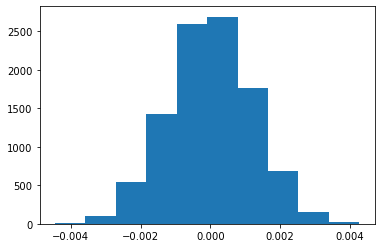

In [31]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
(p_diffs>different).mean() 

0.9049

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

##### Answer :
- The proportion of the p_diffs which are greater than the actual difference observed in ab_data.csv is what we call the **p_value** which is the probability of obtaining the observed statistic or one more extreme in favor of the alternative hypothesis if the null was True
- The null hypothesis was that the difference in means would be equal or less than 0 and the difference is less than zero, and the p-value is very large so We do not have evidence to reject the null 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = len(df2.query('group=="control" & converted==1'))
convert_new = len(df2.query('group=="treatment" & converted==1'))
n_old =len(df2.query('landing_page=="old_page"'))
n_new =len(df2.query('landing_page=="new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

 #### Answer
 - When the p-value is very small, it means it is very unlikely that the observed spatial pattern is the result of random processes, so you can reject the null hypothesis but we see that it's a high probability so we can't reject the null hypothesis
 - as the confidence level is 95% the critical z_score should not be between -1.96 and +1.96 it should falls outside this range  but it is 1.311 in our case so your uncorrected p-value will be larger than 0.05, and you cannot reject your null hypothesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

- simple linear regression because it's between two variables dependant variable (Response) and  independant (Explanatory) and we want to predict the response

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept']=1
df2['ab_page']=0
treatment=df2[df2['group']=='treatment'].index
df2.loc[treatment,'ab_page'] =1
df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  
0          1        0  
1          1        0  
2          1        1  
3          1        1  
4          1        0

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
ln=sm.OLS(df2['converted'],df2[['intercept','ab_page']])
results=ln.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Fri, 08 Jan 2021   Prob (F-statistic):              0.190
Time:                        09:04:27   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**
- The p-value associated with ab_page is 0.190
-   in regression p_values are always given for testing if the parameter for intercept or the slpoe are equal to zero for the null hypothesis  
- In **Part II** The null hypothesis was that the mean converted rate of the old page is greater or equal to the converted rate of the new page and the alternative hypothesis is that the mean converted rate of the new page is greater than the converted rate of the old page.
- In **Part III** The null hypothesis was that the difference between the pages is equal to 0, and the alternative hypothesis was the difference between the pages is greater or less than 0. 
- he difference between p-values of Part 2 and 3 is because we have performed a one-tailed test in Part 2, and in Part 3, we are performing a two-tailed test. two-tailed test allots half of your alpha to testing the statistical significance in one direction and half of your alpha to testing statistical significance in the other direction

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
- It would be a good idea to consider other factors to add into the regression model. Perhaps time of day that the user used the page, might influence when people sign up online.
- The disadvantages is that it could be very complex because variables may affect other variables and may be we are just adding variables that don't affect the outcome

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
country=pd.read_csv('countries.csv')
country.head()

user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK

In [39]:
country_dummies = pd.get_dummies(country['country'])
countries = country.join(country_dummies)

In [40]:
countries.head()

user_id country  CA  UK  US
0   834778      UK   0   1   0
1   928468      US   0   0   1
2   822059      UK   0   1   0
3   711597      UK   0   1   0
4   710616      UK   0   1   0

In [46]:
 df3 = df2.set_index('user_id').join(countries.set_index('user_id'))
df3.sample(5)

timestamp      group landing_page  converted  \
user_id                                                                  
860107   2017-01-23 10:36:06.414526  treatment     new_page          1   
883311   2017-01-13 17:11:21.262211  treatment     new_page          0   
632679   2017-01-14 01:11:41.770081  treatment     new_page          0   
748902   2017-01-05 10:43:36.808537    control     old_page          0   
864173   2017-01-23 12:24:55.390720  treatment     new_page          0   

         intercept  ab_page country  CA  UK  US  
user_id                                          
860107           1        1      US   0   0   1  
883311           1        1      US   0   0   1  
632679           1        1      US   0   0   1  
748902           1        0      US   0   0   1  
864173           1        1      US   0   0   1

In [45]:
ln=sm.OLS(df3['converted'], df3[['intercept', 'UK', 'US']])
results = ln.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Fri, 08 Jan 2021   Prob (F-statistic):              0.201
Time:                        10:11:18   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1153      0.003     42.792      0.000       0.110       0.121
UK             0.0053      0.003      1.787      0.074      -0.001       0.011
US             0.0042      0.003      1.516      0.130      -0.001       0.010
==============================================================================
Omnibus:                   125552.384   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414306.036
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         9.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Answer 
- The correlation coefficient is very small for both UK and US. This means the relationship between country and conversion is weak.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:
df3['UK_ab_page']=df3['UK']*df3['ab_page']
df3['US_ab_page']=df3['US']*df3['ab_page']
df3.head()

timestamp      group landing_page  converted  \
user_id                                                                  
851104   2017-01-21 22:11:48.556739    control     old_page          0   
804228   2017-01-12 08:01:45.159739    control     old_page          0   
661590   2017-01-11 16:55:06.154213  treatment     new_page          0   
853541   2017-01-08 18:28:03.143765  treatment     new_page          0   
864975   2017-01-21 01:52:26.210827    control     old_page          1   

         intercept  ab_page country  CA  UK  US  UK_ab_page  US_ab_page  
user_id                                                                  
851104           1        0      US   0   0   1           0           0  
804228           1        0      US   0   0   1           0           0  
661590           1        1      US   0   0   1           0           1  
853541           1        1      US   0   0   1           0           1  
864975           1        0      US   0   0   1           0           0

In [54]:
ln=sm.OLS(df3['converted'], df3[['intercept','ab_page','UK_ab_page','US_ab_page','UK','US']])
results = ln.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.466
Date:                Fri, 08 Jan 2021   Prob (F-statistic):              0.197
Time:                        13:21:43   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290578   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1188      0.004     31.057      0.000       0.111       0.126
ab_page       -0.0069      0.005     -1.277      0.202      -0.017       0.004
UK_ab_page     0.0080      0.006      1.360      0.174      -0.004       0.020
US_ab_page     0.0047      0.006      0.845      0.398      -0.006       0.016
UK             0.0012      0.004      0.296      0.767      -0.007       0.009
US             0.0018      0.004      0.467      0.641      -0.006       0.010
==============================================================================
Omnibus:                   125549.436   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414285.945
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Answer
- still the correlation cofficient of the countries very small so the relationship between countries and the pages is weak so they don't have that effect on conversion
-  we can see the coefficient of intereaction variable "UK_ab_page" and "US_ab_page" are different from the coefficient of ab_page itself.
-  The score reuslt is very low, which mean the page and country dataset are not a good fit to predit converted rate 
- The p_values of the variables tell us that they are not statistically significant
#### Conclusion
- We can see that the new_page and countries don't effect the convertion rate as the old_page has more convertions so we should stick with the old_page

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [128]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1